In [192]:
'''
==================================================================================
Task 4
Brief explanation: 

The data structure I'm using to create the SQL database is a ditionary myDict wherein
each key in the dictionary is a date2num converted number repreneting a particular 
DateTime instance and the corresponding value to that key is a dictionary with each key as 
a feature and the corresponding value a list containing the values of the particular feature
corresponding to that DateTime instance.

Building the data structure would take O(N) time complexity
but access time for a given feature would be O(N) this way



Note: Due to technical issues, I was without a working machine for a weak and hence 
did not have a resource to work on the task.


Based on the research paper conerning the SuperDARN group of radars, I identified 
some features that would be suitable to feed to the KMeans clustering algorithm.


I have normalized the data by dividing all values of a given feature fo a particular 
DateTime instance by the maximum value of the feature corresponding to that DateTime
instance. 


==================================================================================


Yet to complete:
1. Using the jsons module to dump the structure into a SQL database
2. Running the KMeans algorithm on the data
'''

from sklearn.cluster import KMeans
from davitpy import pydarn
import davitpy.pydarn.sdio
import datetime as dt
from matplotlib.dates import *
import json
import numpy as np

'''
==================================================================================
Loading the data as shown in the documentation of DaVitPy
==================================================================================
'''
sTime = dt.datetime(2011,1,1,1,0)
print sTime


#rad is the 3-letter radar code for the radar we want (reqd input)
rad='bks'

#NOTE:the rest of the inputs are optional
#eTime is the end time we want to read until
eTime = dt.datetime(2011,1,1,10,0)
print eTime

#channel is the radar channel we want data from
#By default this is set to None.
#Note: For certain radars, like the UAF radars, the channel must
#be explicitly identified such as 'a'.
channel=None

#bmnum is the beam number we want data from.  by default this is
#None, which will read data from all beams
bmnum=7

#cp is the control program id number which we want data from
#by default, this is set to None which reads data from all cpids
cp=None

#fileType specifies the type of data we want.  valid inputs are
#'fitex','fitacf','lmfit','rawacf'.  by default this is 'fitex'
#if a fit type is requested but not found, the code will automatically
#look for other fit types
fileType='fitacf'

#filter is a boolean indicating whether to boxcar filter the data.
#this is onyl valid for fit types, and wont work on mongo data
filtered=False

#src is a string indicating the desired data source.  valid
#inputs are 'mongo','local','sftp'.  by default this is set to
#None which will sequentially try all sources
src=None

myPtr = pydarn.sdio.radDataOpen(sTime,rad,eTime=eTime,channel=channel,bmnum=bmnum,cp=cp,fileType=fileType,filtered=filtered, src=src)


myBeam = pydarn.sdio.radDataReadRec(myPtr)

#print myBeam


vel,t ,pwr, spec, elv =[], [], [], [], []
final = []

while(myBeam!= None):
    vel.append(myBeam.fit.v)
    t.append(myBeam.time)
    pwr.append(myBeam.fit.pwr0)
    spec.append(myBeam.fit.w_l)
    elv.append(myBeam.fit.elv)

    myBeam = pydarn.sdio.radDataReadRec(myPtr)
print len(t)
#print vel[0]

2011-01-01 01:00:00
2011-01-01 10:00:00
1080


In [193]:
'''
==================================================================================
Structuring the data
The data obtained from DaVitPy in myBeam is in a very raw form and hence needs
to be structured. The final goal is to have an SQL table of sorts from where the data
can be easily queried. 

As a first step, my idea was that we could introduce some hierarchy to the data.
Since every DateTime object is unique, I thought we could have them as key values in 
a dictionary. Every DateTime object has a range of values (and in the case of some
features like velocity, the length of this range is variable). I thought a good
way to structure the data would be to have a dictionary corresponding to each
key in the parent dictionary, in which the keys would represent the features
like 'velocity', '0 lag power', 'spectral width' and the values corresponding to
each of these keys would be their range of values.
==================================================================================
'''



v_final = []
pwr_final = []
spec_final = []
#ax = gca()
myDict = {}
maxi = -(float("inf"))


for i in range(len(t)):
	myDict[t[i]] = {'vel': [], 'pwr': [], 'spec' :[], 'elv':[]}


for i in range(len(t)):
    if not vel[i]: 
        continue
  
    for j in vel[i]:
    	if j > maxi:
    		maxi = j
    	myDict[t[i]]['vel'].append(j)
    	v_final.append([t[i], j, 'vel'])
for j in v_final:
	j[1] /= float(maxi)


temp_list = []
for i in v_final:
	if i[0] not in temp_list:
		temp_list.append(i[01])

maxi = -(float("inf"))

for i in range(len(t)):
    if not pwr[i]: continue
    for j in pwr[i]:
    	if j > maxi:
    		maxi = j
    	myDict[t[i]]['pwr'].append(j)
    	pwr_final.append([t[i], j, 'pwr'])
for j in pwr_final:
    j[1] /=maxi
maxi = -(float("inf"))

for i in range(len(t)):
    if not spec[i]: continue
    for j in spec[i]:
    	if j > maxi:
    		maxi = j
    	myDict[t[i]]['spec'].append(j)
    	spec_final.append([t[i], j, 'spec'])
        
for i in range(len(t)):
    if not spec[i]: continue
    for j in elv[i]:
    	if j > maxi:
    		maxi = j
    	myDict[t[i]]['elv'].append(j)
for j in spec_final:
	j[1] /=maxi

#dataset = v_final + pwr_final + spec_final

# X = []
# y = []
# for i in dataset:
# 	X.append(i[:2])
# 	y.append(i[2])
#print X[:2]

import random

#print myDict[734138.0419535764]


# import json
# with open('radData.json', 'w') as fp:
# 	json.dump(myDict, fp)

# km = KMeans(n_clusters = 3)

# km.fit(X)


# def ClusterIndices(clustNum, labels_array):
# 	return np.where(labels_array = clustNum)[0]

# print ClusterIndicesNumpy(2, km.labels_)

In [194]:
'''
==================================================================================
Now that the data is structured, it can be converted to a Pandas DataFrame.
Because each feature has a range of values, they can't directly be fed to the KMeans
algorithm. Therefore, the range of values corresponding to each feautures is 
represented by the mean of the values and their standard deviation.


NOTE: Spectral width has some values listed as infinity, which logically makes sense
but I'm currently trying out different functions that would retain the range of values
and at the same time, solve the problem of handling 'INF' values.

NaN values have been converted to zeroes. 
==================================================================================
'''

"\n==================================================================================\nNow that the data is structured, it can be converted to a Pandas DataFrame.\nBecause each feature has a range of values, they can't directly be fed to the KMeans\nalgorithm. Therefore, the range of values corresponding to each feautures is \nrepresented by the mean of the values and their standard deviation.\n\n\nNOTE: Spectral width has some values listed as infinity, which logically makes sense\nbut I'm currently trying out different functions that would retain the range of values\nand at the same time, solve the problem of handling 'INF' values.\n\nNaN values have been converted to zeroes. \n==================================================================================\n"

In [195]:
import pandas as pd
df = pd.DataFrame(myDict).T.reset_index()
df.to_pickle('data')
df.head()

,index,elv,pwr,spec,vel
0,2011-01-01 01:00:24.789,"[32.5968742371, 26.3779563904, 0.0, 24.5486660...","[-0.21833011508, 0.139684632421, 0.30820024013...","[138.740264893, 43.539024353, 0.649335324764, ...","[-48.6440238953, -0.43839764595, -0.3681160807..."
1,2011-01-01 01:01:24.859,"[29.1245040894, 28.8503990173, 25.3504714966, ...","[-1.71682143211, 0.951337575912, -1.3793355226...","[-11.5717201233, -1.23503959179, 50.9993667603...","[-1.339838624, -2.96976041794, -35.8427696228,..."
2,2011-01-01 01:02:24.829,"[0.0, 54.3764801025, 27.047492981, 0.0, 26.579...","[-3.33749198914, 2.22489309311, 0.886046111584...","[772.654846191, 117.049453735, 10.1907663345, ...","[133.909240723, -20.4226570129, -4.31139707565..."
3,2011-01-01 01:03:24.829,"[27.1532363892, 30.3722457886, 24.8747329712, ...","[1.51686275005, -1.67281734943, 1.72117817402,...","[38.8128700256, 50.199180603, -1.54584050179, ...","[-7.65269327164, -5.33034276962, -3.8630540370..."
4,2011-01-01 01:04:24.809,"[28.4291725159, 24.5116138458, 25.0783023834, ...","[-1.8293068409, -1.24938738346, -3.69487380981...","[28.32878685, 1.19291734695, 1.31579649448, 0....","[-5.94937133789, -18.2092704773, -9.2155141830..."


In [196]:

df.columns = ['Time', 'pwr', 'spec', 'vel', 'elv']

In [197]:
variable_cols = ['pwr', 'spec', 'vel', 'elv']

In [202]:
import math
df.loc[6, 'spec']
df['spec'] = df['spec'].apply(lambda x: np.arctan(np.array(x)))
df.loc[6, 'spec']

def fill(array):
    tmp = array.copy()
    for col in variable_cols:
        try:
            
            tmp[col] = array[col]/np.amax(array[col])
        except Exception as e:
            tmp[col] = 0
    return tmp
            
new_df = df.apply(fill, axis = 0)
#new_df = new_df.T
new_df.head()

,Time,pwr,spec,vel,elv
0,2011-01-01 01:00:24.789000,"[32.5968742371, 26.3779563904, 0.0, 24.5486660...","[-0.20287226006789244, 0.1353601402584937, 0.2...","[138.740264893, 43.539024353, 0.649335324764, ...","[-48.6440238953, -0.43839764595, -0.3681160807..."
1,2011-01-01 01:01:24.859000,"[29.1245040894, 28.8503990173, 25.3504714966, ...","[-0.5377167619646137, 0.4818420653393267, -0.5...","[-11.5717201233, -1.23503959179, 50.9993667603...","[-1.339838624, -2.96976041794, -35.8427696228,..."
2,2011-01-01 01:02:24.829000,"[0.0, 54.3764801025, 27.047492981, 0.0, 26.579...","[-0.5658169886045714, 0.5516818268672387, 0.47...","[772.654846191, 117.049453735, 10.1907663345, ...","[133.909240723, -20.4226570129, -4.31139707565..."
3,2011-01-01 01:03:24.829000,"[27.1532363892, 30.3722457886, 24.8747329712, ...","[0.5291477296348668, -0.5360338037849961, 0.53...","[38.8128700256, 50.199180603, -1.54584050179, ...","[-7.65269327164, -5.33034276962, -3.8630540370..."
4,2011-01-01 01:04:24.809000,"[28.4291725159, 24.5116138458, 25.0783023834, ...","[-0.5415942552553777, -0.5126423672561413, -0....","[28.32878685, 1.19291734695, 1.31579649448, 0....","[-5.94937133789, -18.2092704773, -9.2155141830..."


In [203]:
df.fillna(0)
        
for col in variable_cols:
    df[col + '_mean'] = df[col].apply(lambda x: np.array(x).mean())
    df[col + '_std'] = df[col].apply(lambda x: np.array(x).std())
# spectral = ['spec']
# for col in spectral:
#     df[col + '_mean'] = df[col].apply(lambda x: math.tan(x))
#     df[col + '_std'] = df[col].apply(lambda x: math.tan(x))

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice.
  after removing the cwd from sys.path.


In [204]:
from sklearn.manifold import TSNE

In [205]:
df = new_df.fillna(0)

In [162]:
tsne = TSNE()

In [164]:
new_df.head()

Time    None
pwr     None
spec    None
vel     None
elv     None
dtype: object

In [152]:
new_df.head()
#plot = tsne.fit_transform(new_df.drop(['Time', 'pwr', 'spec', 'vel', 'elv'], axis = 1))

Time    None
pwr     None
spec    None
vel     None
elv     None
dtype: object

In [119]:
%matplotlib inline

In [120]:
import matplotlib.pyplot as plt

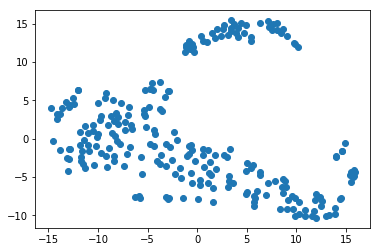

In [121]:
'''
==================================================================================
TSNE is similar to PCA in the sense that it maps features of multiple dimensions down
to 2 dimensions. This function provides a nice visual representation to how
the datapoints might look like.
Note however that the axes have no physical meaning. 
==================================================================================
'''
plt.scatter(plot[:, 0], plot[:, 1])

In [122]:
km = KMeans(n_clusters =4)

In [123]:
km = km.fit(df.drop(['Time', 'pwr', 'spec', 'vel', 'elv' ], axis = 1))

In [124]:
df['cluster'] = km.predict(df.drop(['Time', 'pwr', 'spec', 'vel', 'elv' ], axis = 1))
num_clusters = df['cluster'].nunique()

In [125]:
df

,Time,pwr,spec,vel,elv,pwr_mean,pwr_std,spec_mean,spec_std,vel_mean,vel_std,elv_mean,elv_std,cluster
0,2011-01-01 01:00:24.789,"[0.5919812701402627, 0.4790415183406935, 0.0, ...","[-0.1418930418398806, 0.09161302157166644, 0.1...","[0.21555828200147725, 0.06764580777487843, 0.0...","[-4.549150660076471, -0.04099860128234663, -0....",0.415000,0.186182,-0.256637,0.692031,0.109120,0.252411,-0.499280,1.338111,0
1,2011-01-01 01:01:24.859,"[0.49620099652065913, 0.4915310042189486, 0.43...","[-0.6830908609089307, 0.49787653701964274, -0....","[-0.1521481150670349, -0.01623863556340942, 0....","[1.4117282137866118, 3.129104128728568, 37.765...",0.403939,0.232639,-0.232153,0.738432,0.290485,0.356335,8.578163,7.560770,0
2,2011-01-01 01:02:24.829,"[0.0, 1.0, 0.4974116185886418, 0.0, 0.48880894...","[-0.839113020332963, 0.753023063725987, 0.4754...","[1.0, 0.15148996257813602, 0.01318928676208571...","[1.0, -0.1525111852081775, -0.0321964119308431...",0.467615,0.210063,-0.205741,0.738530,0.082633,0.220892,-0.075184,0.471744,0
3,2011-01-01 01:03:24.829,"[0.8751181101684564, 0.9788631437937783, 0.801...","[0.6470931404915504, -0.6759509889282675, 0.68...","[0.06109393815343011, 0.07901671876077822, -0....","[-0.38626302580988137, -0.2690444074675309, -0...",0.628228,0.375703,-0.114959,0.668183,0.158477,0.295482,-1.074778,3.594035,0
4,2011-01-01 01:04:24.809,"[1.0, 0.8621993423179247, 0.882132688505941, 0...","[-0.7023815173485901, -0.5877535869583411, -0....","[0.4628981321003049, 0.01949251178949422, 0.02...","[2.470945623588811, 7.5628355735767006, 3.8274...",0.730185,0.317890,-0.291468,0.673145,0.328256,0.299615,3.354674,1.826009,0
5,2011-01-01 01:05:24.769,"[0.3897708191707017, 0.4117017284650992, 0.474...","[-0.8952537696586528, -0.3062186274971624, -0....","[0.013918166998203856, 0.02561552854592166, 0....","[-2.6611209442749493, -3.6496716297868153, -0....",0.327019,0.221580,-0.458684,0.674759,0.067701,0.214973,-3.348705,2.021415,0
6,2011-01-01 01:06:24.919,"[0.42113802663907113, 0.44598120974814814, 0.4...","[0.17518263793131453, 0.9636146716272639, -0.7...","[0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[-0.19602430310627295, -0.21950811749291543, -...",0.605967,0.320029,-0.172317,0.687108,0.000000,0.000000,-8.002208,17.747429,3
7,2011-01-01 01:07:24.859,"[0.0, 0.0, 1.0, 0.4950267593832939, 0.47534505...","[0.934269097624428, 0.4020269633351254, 0.9820...","[0.005167889667186383, 0.849091618753149, 0.14...","[2.2384136593930344, 2.1274098364172658, 7.958...",0.404501,0.228104,-0.195322,0.729597,0.175552,0.296594,3.227056,1.311698,0
8,2011-01-01 01:08:24.829,"[0.7484810665911746, 0.7246055620561811, 0.971...","[0.4257990367194609, -0.24239958648862897, -0....","[0.4040357405926166, -0.10607123939633681, -0....","[1.399512990284436, 1.0, 4.751167815711045, 2....",0.755016,0.265437,-0.235717,0.698524,0.251236,0.360855,3.328521,1.583266,0
9,2011-01-01 01:09:24.779,"[0.46727958347285203, 0.49472329216280736, 0.0...","[0.6986242705203874, 0.5971805618023623, -0.90...","[0.08539318030227684, -0.032011655173322814, 0...","[0.4481732959452675, 1.0, -1.0032363439120897,...",0.414715,0.198543,-0.091100,0.688756,0.075925,0.226579,-0.844534,2.707926,0


In [126]:
for col in variable_cols:
    df[col] = df[col].apply(lambda x: len(x))

In [127]:
df.head()

,Time,pwr,spec,vel,elv,pwr_mean,pwr_std,spec_mean,spec_std,vel_mean,vel_std,elv_mean,elv_std,cluster
0,2011-01-01 01:00:24.789,23,140,23,23,0.415000,0.186182,-0.256637,0.692031,0.109120,0.252411,-0.499280,1.338111,0
1,2011-01-01 01:01:24.859,20,140,20,20,0.403939,0.232639,-0.232153,0.738432,0.290485,0.356335,8.578163,7.560770,0
2,2011-01-01 01:02:24.829,19,140,19,19,0.467615,0.210063,-0.205741,0.738530,0.082633,0.220892,-0.075184,0.471744,0
3,2011-01-01 01:03:24.829,16,140,16,16,0.628228,0.375703,-0.114959,0.668183,0.158477,0.295482,-1.074778,3.594035,0
4,2011-01-01 01:04:24.809,13,140,13,13,0.730185,0.317890,-0.291468,0.673145,0.328256,0.299615,3.354674,1.826009,0


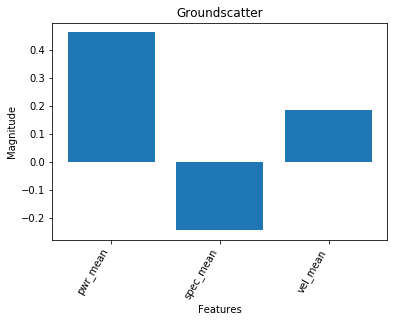

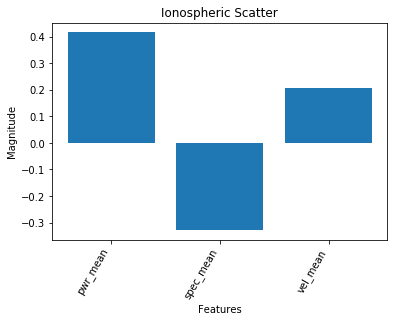

,Time,pwr,spec,vel,elv,pwr_mean,pwr_std,spec_mean,spec_std,vel_mean,vel_std,elv_mean,elv_std,cluster
0,2011-01-01 01:00:24.789,23,140,23,23,0.415000,0.186182,-0.256637,0.692031,0.109120,0.252411,-0.499280,1.338111,0
1,2011-01-01 01:01:24.859,20,140,20,20,0.403939,0.232639,-0.232153,0.738432,0.290485,0.356335,8.578163,7.560770,0
2,2011-01-01 01:02:24.829,19,140,19,19,0.467615,0.210063,-0.205741,0.738530,0.082633,0.220892,-0.075184,0.471744,0
3,2011-01-01 01:03:24.829,16,140,16,16,0.628228,0.375703,-0.114959,0.668183,0.158477,0.295482,-1.074778,3.594035,0
4,2011-01-01 01:04:24.809,13,140,13,13,0.730185,0.317890,-0.291468,0.673145,0.328256,0.299615,3.354674,1.826009,0


In [128]:
clusters = []
variable_cols += ['pwr_mean', 'pwr_std', 'spec_mean', 'spec_std', 'vel_mean', 'vel_std', 'elv_mean', 'elv_std']
final_cols = ['pwr_mean', 'vel_mean', 'spec_mean']
ground = []
ionosphere = []
backscatter = [pd.DataFrame(), pd.DataFrame()]
for i in range(num_clusters):
    clusters.append(df[df['cluster'] == i])
    
    if(np.array(clusters[i]['elv_mean']).mean()>0):
        ground.append(clusters[i])
        backscatter[0] = backscatter[0].add(clusters[i]) #Ionospheric Scatter
    else:
        ionosphere.append(clusters[i])
        backscatter[1] = backscatter[1].add(clusters[i]) #Groundscatter
backscatter[0] = pd.concat(ground)
backscatter[1] = pd.concat(ionosphere)
for i in range(len(backscatter)):    
    dict_of_features = {} 
    for col in final_cols:
        dict_of_features[col] = np.array(backscatter[i][col]).mean()
    if(i==0):
        plt.title('Groundscatter')
    else:
        plt.title('Ionospheric Scatter')
    plt.xlabel('Features')
    plt.ylabel('Magnitude')
    plt.bar(range(len(dict_of_features)), dict_of_features.values(), align = 'center',linewidth=1.5)
    plt.xticks(range(len(dict_of_features)), dict_of_features.keys(),rotation=60, horizontalalignment='right')
    plt.show()
backscatter[0].head()
   